#Agglomerative Clustering of Text Embeddings

In this notebook, we apply Agglomerative Clustering to group semantically similar articles based on their vector representations (embeddings). The embeddings were previously generated using a SentenceTransformer model and represent each article in a high-dimensional semantic space.

Agglomerative clustering is a hierarchical bottom-up clustering method. Unlike flat clustering techniques such as K-Means, this approach:

* Starts with each document as its own cluster,
* Iteratively merges the most similar clusters based on a selected distance metric (cosine),
* Forms a dendrogram representing cluster hierarchies.

We chose this method because:

* It does not assume spherical or equal-sized clusters,

* It is more interpretable and suitable for our document-based domain,

* It performs well with cosine similarity and pre-computed sentence embeddings.

After clustering, we visualize the results using UMAP, reduce dimensionality to 2D space, and interpret the cluster distribution and quality using both intrinsic metrics and top keywords.

###Import modules

* AgglomerativeClustering - hierarchical clustering algorithm from scikit-learn

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import torch

In [ ]:
embeddings = np.load("/content/mbart_embeddings.npy")

df = pd.read_csv("/content/mbart_summary_dataset.csv")

##Creating the model

* n_clusters = 8 - we are dividing texts into 8 groups since there were 8 main categories of 15min.lt news
* metric="cosine" - specifies to use cosine distance, which is very suitable for text embeddings
* linkage="average" - calculates the average distance between points in different clusters

**Since sklearn version 1.2, metric should be used instead of affinity**

* df["cluster"] = agglo_model.fit_predict(embeddings) - each embedding is assigned a cluster. fit_predict() fits the model and returns the cluster number for each record. These numbers are stored in df["cluster"]
* sort_index() - allows you to display clusters in an orderly manner from 0 to n

In [ ]:
n_clusters = 8

agglo_model = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric="cosine",
    linkage="average"
)

df["cluster"] = agglo_model.fit_predict(embeddings)


print(f"Clusters are assigned. Cluster distribution:\n{df['cluster'].value_counts().sort_index()}")

df.to_csv("/content/mbart_clustered.csv", index=False)

##Results

We can see, that out of 8 clusters, 5 constitutes the majority

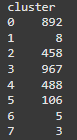

#UMAP Visualization of Agglomerative Clusters

To explore and better understand the structure of the generated clusters, we apply UMAP (Uniform Manifold Approximation and Projection) to reduce the high-dimensional sentence embeddings to a 2D space.

UMAP helps us:

* Visualize semantic proximity between documents,
* Observe how well-defined or overlapping the clusters are,
* Identify potential outliers or subclusters.

Each point on the plot represents an article, and the color indicates its assigned cluster. Closer points are more semantically similar based on their embeddings.

##Import modules

In [ ]:
import umap
import matplotlib.pyplot as plt

###UMAP model
* UMAP uses the n_neighbors hyperparameter, which controls how many local neighbors for each point will be considered when reducing the dimension
* Lower values ​​(5–15) - more local structures (smaller clusters, detailed contours)
* Higher values ​​(30–50) - more global structure (larger formations)

**25 chosen as a balance between detailed locality and maintaining the overall structure**

* min_dist=0.0 - allows points to merge in low dimension (dense clusters without gaps)
* metric="cosine" - calculates the distance between insertions based on cosine similarity (optimal for texts)
* random_state=2025 - the UMAP algorithm uses random initialization to begin optimizing the placement of points in low dimension. Without random_state: Each run can yield different coordinates, even using the same data and parameters

###UMAP embeddings
* umap_embeddings = umap_model.fit_transform(embeddings) - fit_transform() reduces the dimension of the embeddings (for example from 384 to 2 (UMAP X and Y))

###Adding coordinates to DataFrame
* df["umap_x"] = umap_embeddings[:, 0] and df["umap_y"] = umap_embeddings[:, 1] - each line contains 2D coordinates (UMAP projection) — they will be used in the drawing

###Adding visualization with UMAP
* c=df["cluster"] - the color is selected according to the cluster (from 0 to 7)
* cmap="tab10" - 10 color palette
* s=10 - point size
* alpha=0.7 - transparency (helps when many points overlap)



In [ ]:
umap_model = umap.UMAP(n_neighbors=25, min_dist=0.0, metric="cosine", random_state=2025)
umap_embeddings = umap_model.fit_transform(embeddings)

df["umap_x"] = umap_embeddings[:, 0]
df["umap_y"] = umap_embeddings[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"], c=df["cluster"], cmap="tab10", s=10, alpha=0.7
)
plt.title("UMAP visualization with clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Clusters")
plt.grid(True)

plot_path = "/content/umap_clusters.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"UMAP visualization saved to: {plot_path}")

### Results of visualization with UMAP

The clustering results show how the articles have grouped into clearly distinct groups based on their semantic similarity. This structure indicates that the articles in the clusters have similar topics or speaking styles. Visually, it can be seen that some clusters are clearly distinct, while others have slight overlap, requiring additional evaluation or interpretation.



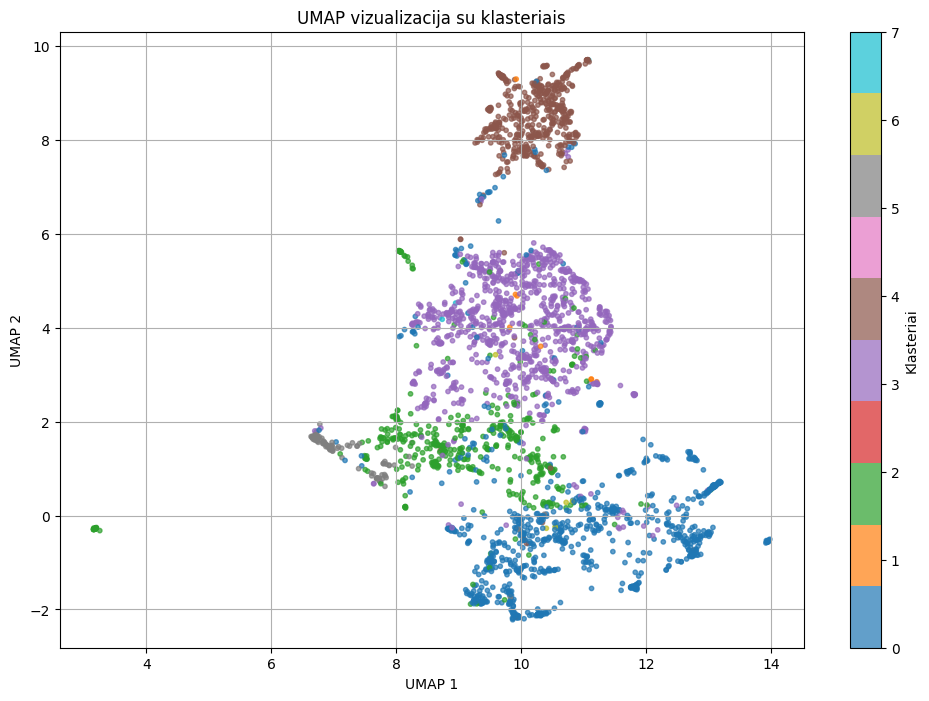

###Metrics

Two main metrics will be used to measure the quality of clusterization.
* Silhouette score - measures how well each point is assigned to its cluster compared to other clusters. Result will be between -1 and 1, the closer to 1 the better.
For each point, we calculate
a – the average distance to other points in its cluster.
b – the average distance to points in the nearest other cluster.
* metric="cosine" - for text embeddings, cosine distance is more suitable (because direction is important, not absolute distance).

* Davies-Bouldin score - Evaluates the density and separation of clusters from each other. The smaller the number the better result



In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(embeddings, df["cluster"], metric="cosine")

davies = davies_bouldin_score(embeddings, df["cluster"])

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies:.4f}")

###Results of Silhouette score and Davies-Bouldin score

Silhouette Score = 0.0593
This score is very close to 0, so the clusters are not clearly and strictly separated from each other. The articles overlap somewhat in topics, so the clustering is of medium to weak clarity. The results show that the data are semantically related, but there are no very clear boundaries between the clusters.

Davies-Bouldin Index = 3.5836
A Davies-Bouldin index above 3 indicates that the clusters are poorly compact and have significant overlap. The higher this value, the less distinct the clusters are, so this result supports the interpretation of the Silhouette Score about the average level of cluster separation.

The clustering results show that the resulting groups are not very clear or strictly separated. However, clustering still has some informative value because the groups share common themes or semantic logic.

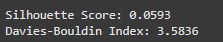

### TOP words in eatch cluster
We will use TF-IDF (Term Frequency–Inverse Document Frequency) method to analyze the text set of each cluster and extract the most important words — this helps to describe the clusters semantically. The main intent is to find the most common, but also informative words in each cluster using the mbart_summary field. TF: How often does the word occur in the text. IDF: How rare is the word in all texts.

* TfidfVectorizer - a tool in the scikit-learn library for converting texts into numerical vectors based on TF-IDF weights.
* lt_stopwords - words that have no semantic value, such as conjunctions ("and", "that", "with"), and are removed from the analysis. This improves the assessment of word significance

###Function for TOP words using TF-IDF
* clusters = sorted(dataframe[cluster_column].unique()) - goes through all clusters
* cluster_texts = dataframe[dataframe[cluster_column] == cluster_id][text_column].fillna("").tolist() - filters texts for each cluster
* tfidf = TfidfVectorizer(stop_words=lt_stopwords, max_features=1000) - creates a TF-IDF vectorizer. max_features Limits the number of words analyzed to 1000 (most frequent) and stop_words throws out irrelevant words
* tfidf_matrix = tfidf.fit_transform(cluster_texts) - processes the cluster texts and converts them into a numerical TF-IDF matrix that reflects the importance of each word in each text
* scores = tfidf_matrix.sum(axis=0).A1 - Counts the total value of each word in the cluster. Since sum(axis=0) returns a 2D matrix, A1 is a way to convert a numpy matrix object to a 1D numpy array to make it easier to work with the values
* words = tfidf.get_feature_names_out() - returns the dictionary (all unique words) that TfidfVectorizer learned from the cluster texts. Each word corresponds to one column in the tfidf_matrix matrix
* sorted_indices = scores.argsort()[::-1][:n_top_words] - Sorts by importance and takes the TOP n
* top_words_list.append({"cluster": cluster_id, "top_words": ", ".join(top_words)}) - adds to the result list



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("/content/mbart_clustered.csv")

lt_stopwords = [
    "ir", "kad", "su", "yra", "apie", "kaip", "tačiau", "dėl", "buvo",
    "nuo", "už", "iki", "tarp", "nes", "ar", "kuris", "kur", "kas", "ką",
    "vis", "jo", "jos", "jų", "turi", "būti", "todėl", "nei", "o", "bet",
    "labai", "iš", "po", "ji", "taip", "gali", "tiek", "prieš", "pat", "bei",
    "jis", "savo", "tekste", "per", "bus", "ne", "kai", "tai", "siekiant",
    "pabrėžia", "pabrėžiant", "vyks", "metu", "teigia", "siekia", "dar",
    "siekdama", "tik", "įskaitant", "įskaitant", "kurie"
    ]

def get_top_words_per_cluster(dataframe, text_column, cluster_column, n_top_words=10):
    clusters = sorted(dataframe[cluster_column].unique())
    top_words_list = []

    for cluster_id in clusters:
        cluster_texts = dataframe[dataframe[cluster_column] == cluster_id][text_column].fillna("").tolist()
        tfidf = TfidfVectorizer(
            stop_words=lt_stopwords,
            max_features=1000
        )
        tfidf_matrix = tfidf.fit_transform(cluster_texts)
        scores = tfidf_matrix.sum(axis=0).A1
        words = tfidf.get_feature_names_out()
        sorted_indices = scores.argsort()[::-1][:n_top_words]
        top_words = [words[i] for i in sorted_indices]
        top_words_list.append({"cluster": cluster_id, "top_words": ", ".join(top_words)})

    return pd.DataFrame(top_words_list)

top_words_df = get_top_words_per_cluster(df, "mbart_summary", "cluster", n_top_words=15)
top_words_df.to_csv("/content/top_words_per_cluster.csv", index=False)

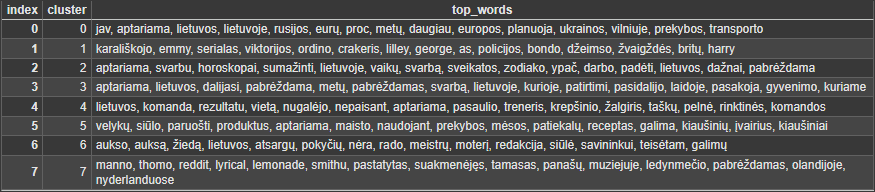

###Cluster distribution
In order to see a more detailed distribution of articles in clusters, we will extract 50 articles from each cluster and perform further analysis.

* n_samples_per_cluster = 50 - the first 50 articles are collected from each cluster
* sorted(df["cluster"].unique()) - sort cluster IDs
* cluster_samples = df[df["cluster"] == cluster_id].head(n_samples_per_cluster) - filter data by cluster ID and take the first 50
* cluster_samples.iterrows() - iterates over each row in the selected cluster
* rows.append - only the important columns are added to the rows list: cluster ID, name, and summary

In [ ]:
df = pd.read_csv("/content/mbart_clustered.csv")

n_samples_per_cluster = 50
rows = []

for cluster_id in sorted(df["cluster"].unique()):
    cluster_samples = df[df["cluster"] == cluster_id].head(n_samples_per_cluster)
    for _, row in cluster_samples.iterrows():
        rows.append({
            "Cluster": cluster_id,
            "Title": row["Title"],
            "Summary": row["mbart_summary"]
        })

typical_df = pd.DataFrame(rows)
typical_df.to_csv("/content/typical_cluster_examples_50.csv", index=False)

## Results of 10 examples



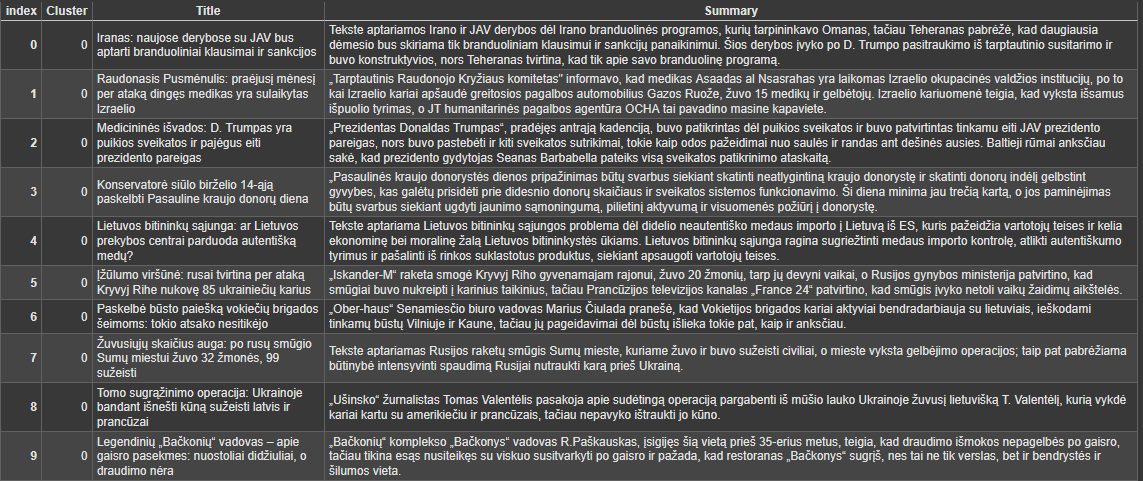

###Adding categories to the clusters
For better cluster representation, we will add original categories names to have a better understanding of the consistency of the clusters

In [ ]:
df_clusters = pd.read_csv("/content/typical_cluster_examples_50.csv")
df_categories = pd.read_csv("/content/mbart_summary_dataset.csv")

df_merged = df_clusters.merge(df_categories[["Title", "Main_category"]], on="Title", how="left")

df_merged.to_csv("/content/typical_cluster_examples_with_categories_50.csv", index=False)

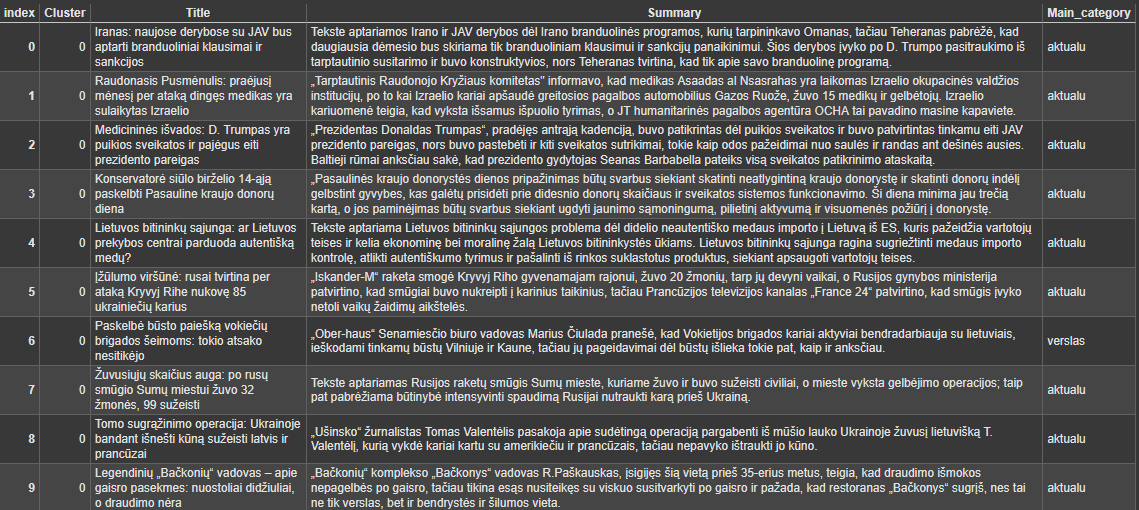

In [ ]:
df = pd.read_csv("/content/typical_cluster_examples_with_categories_50.csv")

cluster_counts = df["Cluster"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind="bar", color="skyblue")
plt.title("Claster size")
plt.xlabel("Clasters")
plt.ylabel("Article number")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

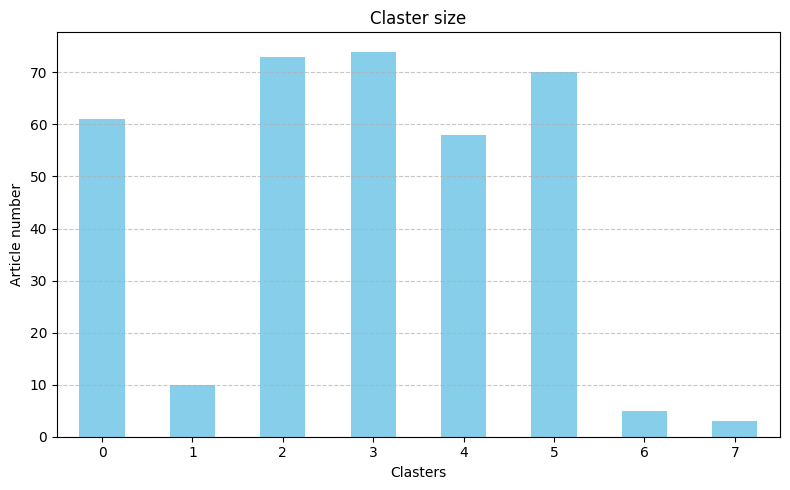

In [ ]:
grouped = df.groupby(["Cluster", "Main_category"]).size().unstack(fill_value=0)

grouped.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Kategorijų pasiskirstymas pagal klasterius")
plt.xlabel("Klasteris")
plt.ylabel("Straipsnių skaičius")
plt.xticks(rotation=0)
plt.legend(title="Tema", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

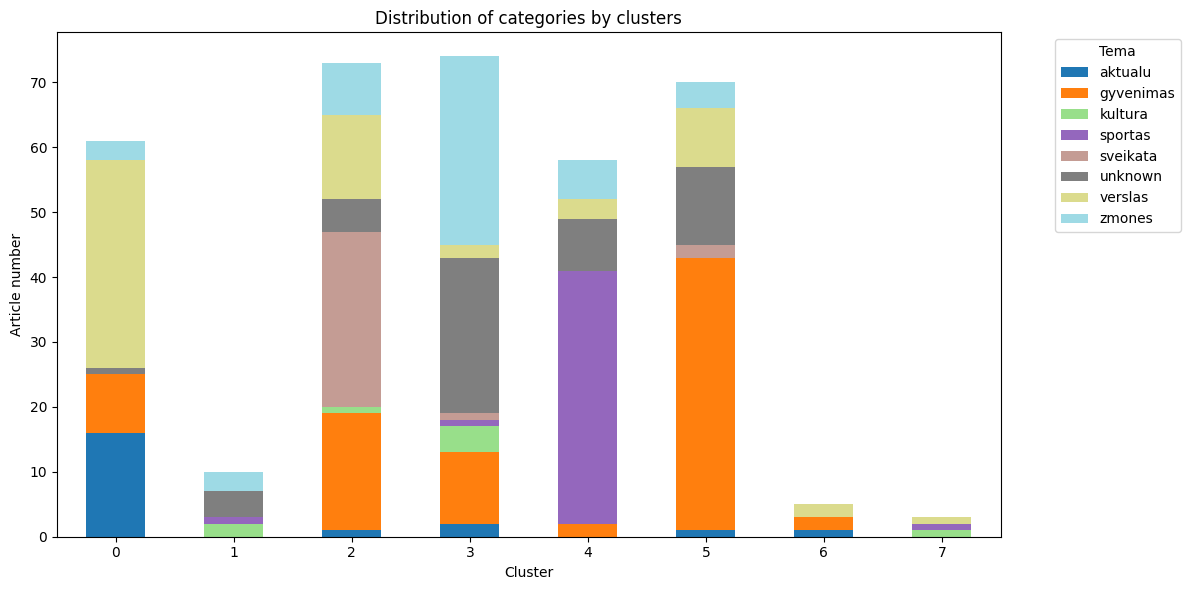

###Adding titles to UMAP Visualization of Agglomerative Clusters

* We will assign cluster names based on TF-IDF top words or typical names
* min_dist=0.3 - minimum distance between points (a slight increase from previous UMAP vizualization)
* hue="cluster" - color depends on cluster
* palette="tab10" - 10 color palette
* legend="full" - legend is displayed
* ha="center", va="center" - precise positioning: ha and va ensure that the name is exactly at the centroid location
* bbox - helps to separate text from the background of a graph, even if it contains other points

In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/mbart_clustered.csv")

reducer = umap.UMAP(n_neighbors=25, min_dist=0.3, random_state=2025)
embeddings_2d = reducer.fit_transform(embeddings)

df["UMAP_1"] = embeddings_2d[:, 0]
df["UMAP_2"] = embeddings_2d[:, 1]

cluster_labels = {
    0: "Lietuvos aktualijos",
    1: "Socialiniai tinklai ir internetas",
    2: "Ekonomika ir verslas",
    3: "Tarptautinė politika",
    4: "Sportas ir renginiai",
    5: "Pramogos ir kultūra",
    6: "Sveikata ir socialiniai klausimai",
    7: "Šventės ir minėjimai",
}

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue="cluster", palette="tab10", s=50, legend="full")

# The center point (average) of each cluster is calculated to assign a name.
for cluster in df["cluster"].unique():
    cluster_data = df[df["cluster"] == cluster]
    centroid_x = cluster_data["UMAP_1"].mean()
    centroid_y = cluster_data["UMAP_2"].mean()
# The name (from cluster_labels) is written on the center of the cluster, making it bold and visible.
    plt.text(centroid_x, centroid_y, cluster_labels[cluster],
             fontsize=12, fontweight="bold",
             ha="center", va="center",
             bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))

plt.title("UMAP Visualization with Cluster Names")
plt.grid(True)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("/content/umap_with_labels.png", dpi=300)
plt.show()

###Results of visualization with UMAP with titles

Adding names to clusters makes it easier to interpret the results. Each cluster represents a clear thematic category (e.g., Sportas ir renginiai, Ekonomika ir verslas, Lietuvos aktualijos). This makes it easier to identify and understand which topics are dominant and which articles on which topics are most similar to each other. This is useful when analyzing large collections of text and understanding their internal structure.

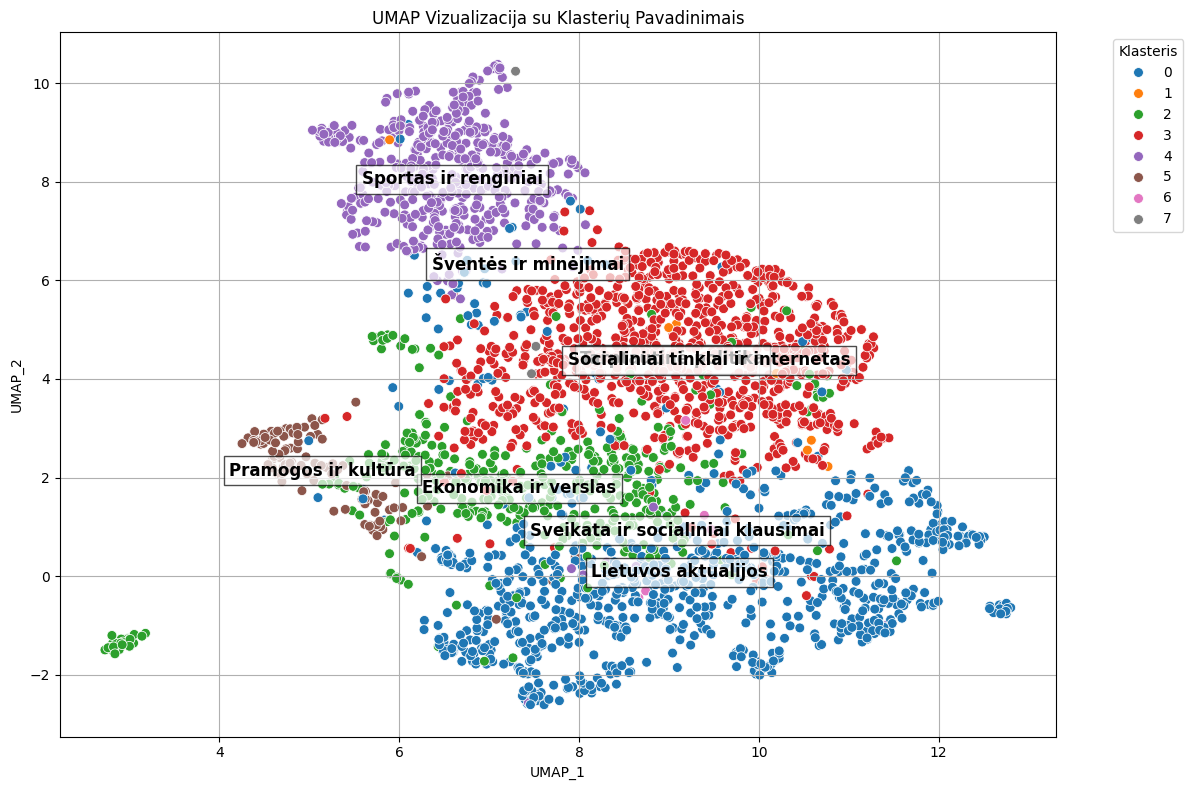